In [1]:
from tqdm import tqdm
import numpy as np
from io import StringIO

In [2]:
import openai

with open("secret/secret_key_file.txt", 'r') as file:
    api_key = file.read().strip()

client = openai.OpenAI(api_key = api_key)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from bs4 import BeautifulSoup

# Without error capture to ensure the output (whether success or failure) is reported back.
# Attempt to read tables from the HTML file using pandas
file_path = "data/Program - MSR 2022.html"

In [4]:
with open(file_path, 'r') as file:
    html_content = file.read()

In [5]:
soup = BeautifulSoup(html_content, 'lxml')

In [6]:
rows = soup.find_all('tr', class_='hidable')

In [7]:
# Regex to match date pattern (e.g., "Tue 16 May")
date_pattern = re.compile(r"\b(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun)\s\d{1,2}\s(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)")

In [8]:
extracted_rows = []

# Loop through each row to extract required details
for row in rows:
    temp_row = []
    
    # Extract session details from parent div if not already extracted
    session_div = row.find_previous('div', class_='session-info-in-table')
    session = session_div.get_text(strip=True) if session_div else ''
    
    datetime_info = row.find('td', class_='text-right')
    talk_info = row.find_all('td')[-1]
    
    if datetime_info and talk_info:
        time = datetime_info.find('div', class_='start-time').get_text(strip=True) if datetime_info.find('div', class_='start-time') else ''
        duration = datetime_info.find('strong').get_text(strip=True) if datetime_info.find('strong') else ''
        
        # Calculate end time based on start time and duration if needed
        
        temp_row.append(time)
        # temp_row.append(end_time)  # Calculate and append end time if needed
        temp_row.append(duration)
        
        talk_title = talk_info.find('strong')
        if talk_title:
            temp_row.append(talk_title.get_text(strip=True))
            
            link = talk_title.find('a', href=True)
            temp_row.append(link['href'] if link else '')
        else:
            temp_row.extend(['', ''])
            
        # Extract authors
        authors_div = talk_info.find('div', class_='performers')
        authors = [author.get_text(strip=True) for author in authors_div.find_all('a')] if authors_div else []
        temp_row.append(authors)
        
        # Append session information
        temp_row.append(session)
        
        # Locate date information
        # Tip: You may need to adjust how you locate the 'date information' based on your HTML structure
        date_info = row.find_previous('div', class_='day-wrapper')
        if date_info:
            date_text = date_info.get_text(strip=True)
            matched_date = date_pattern.search(date_text)
            date = matched_date.group(0) if matched_date else "Date Not Found"
        else:
            date = None
        temp_row.append(date)
        
        extracted_rows.append(temp_row)

columns = ['Time', 'Duration', 'Talk Title', 'Link', 'Authors', 'Session', 'Date']
df = pd.DataFrame(extracted_rows, columns=columns)

df.head()

,Time,Duration,Talk Title,Link,Authors,Session,Date
0,22:00,4m,An Empirical Evaluation of GitHub Copilot’s Co...,#,"[Nhan Nguyen, Sarah Nadi]",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
1,22:04,4m,Comments on Comments: Where Code Review and Do...,#,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
2,22:08,7m,Does This Apply to Me? An Empirical Study of T...,#,"[Akalanka Galappaththi, Sarah Nadi, Christoph ...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
3,22:15,7m,Towards Reliable Agile Iterative Planning via ...,#,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
4,22:22,7m,BotHunter: An Approach to Detect Software Bots...,#,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May


In [9]:
# Convert all column names to lowercase and replace spaces with hyphens
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Put date first
df = df[['date'] + [col for col in df.columns if col != 'date']]

# Convert Time to start_time as datetime and calculate end_time
df['start_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%a %d %b %H:%M')
df['duration'] = df['duration'].str.extract('(\d+)').astype(int)  # Extract duration in minutes
df['end_time'] = df['start_time'] + pd.to_timedelta(df['duration'], unit='m')

# Delete the Link column
df = df.drop(['link', 'time'], axis=1)

# Move Authors column to the last position
df = df[[col for col in df.columns if col != 'authors'] + ['authors']]

df = df[['session', 'date', 'start_time', 'end_time', 'duration', 'talk_title','authors']]

# Display the final data frame
df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:00:00,1900-05-17 22:04:00,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:04:00,1900-05-17 22:08:00,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:08:00,1900-05-17 22:15:00,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:15:00,1900-05-17 22:22:00,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:22:00,1900-05-17 22:29:00,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [10]:
df['start_time'] = pd.to_datetime(df['start_time']).astype(int) // 10**9 // 60
df['end_time'] = pd.to_datetime(df['end_time']).astype(int) // 10**9 // 60

df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619320,-36619316,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619316,-36619312,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619312,-36619305,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619305,-36619298,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619298,-36619291,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [11]:
df.shape

(187, 7)

In [12]:
sessions = df.groupby("session").size()
valid_sessions = sessions[sessions>3].index
df = df[df.session.isin(valid_sessions)]

In [13]:
delete_talk_title = "Discussions and Q&A"
df = df[df.talk_title!=delete_talk_title]

In [14]:
df = df[~df.session.str.startswith("Blended")]

In [15]:
df.shape

(125, 7)

In [16]:
df.dtypes

session       object
date          object
start_time     int64
end_time       int64
duration       int64
talk_title    object
authors       object
dtype: object

In [17]:
def merge_intervals(intervals):
    if not intervals:
        return 0
    
    # Sort intervals by the start time
    intervals.sort(key=lambda x: x[0])
    
    merged = [intervals[0]]
    for current_start, current_end in intervals[1:]:
        last_end = merged[-1][1]
        
        if current_start <= last_end:
            # There's an overlap, extend the previous interval
            merged[-1] = (merged[-1][0], max(last_end, current_end))
        else:
            # No overlap, add this interval as is
            merged.append((current_start, current_end))
    
    # Compute total duration in minutes (or another unit as desired)
    total_duration_minutes = sum((end - start) for start, end in merged)   # convert seconds to minutes
    return total_duration_minutes

total_durations = []

for date, group in df.groupby('date'):
    intervals = list(zip(group['start_time'], group['end_time']))
    total_duration = merge_intervals(intervals)
    total_durations.append({'date': date, 'total_duration': total_duration})

# Converting the result into a DataFrame
total_duration_df = pd.DataFrame(total_durations)

total_duration_df

,date,total_duration
0,Fri 20 May,147
1,Thu 19 May,314
2,Tue 17 May,36
3,Wed 18 May,238


In [18]:
dates = df.groupby("date")["duration"].sum().reset_index()


dates

,date,duration
0,Fri 20 May,147
1,Thu 19 May,314
2,Tue 17 May,36
3,Wed 18 May,238


## Get Schedule through GPT


In [19]:
NUM_SESSION_LIST = [2,3,5,10,len(df.session.unique())] # number of sessions we will consider
SESSION_SIZE_LIST = [2, 5, 10] # number of papers in each session. 10 = "All papers".  

In [20]:
N_ITERATIONS = 10 # we want to get confidence intervals

In [21]:
prompt_template = """
Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event should only be at the end of a session if present. 
4. All papers must be assigned to some session. 

The output should contain the schedule in the form of the csv representation of a data frame. This csv representation should be in three quotes (```) on both sides so that I can easily extract it from your result and make a data frame. 
Example output format(use as many rows as the actual number of papers):

```
session@talk_title@duration
231@An Empirical Study on Maintainable Method Size in Java@7
223@Improve Quality of Cloud Serverless Architectures through Software Repository Mining@7
15@Extracting corrective actions from code repositories@7
15@How to Improve Deep Learning for Software Analytics (a case study with code smell detection)@7
11@ReCover: a Curated Dataset for Regression Testing Research@4
```

The list of paper and session titles are below: 

Session Lengths:
{sessions_df_string}

Paper durations:
{papers_df_string}


Make sure, above all else, that your response is formatted as requested, with the proper headers.

"""

# Print the start_prompt to verify
print(prompt_template[:500])


Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event


In [22]:
def evaluate_schedule(df_human, df_llm):
    sessions_human = df_human.groupby("session")["duration"].sum().sort_values(ascending=False)
    sessions_llm = df_llm.groupby("session")["duration"].sum().sort_values(ascending=False)
    
    result = {}
    
    result["constraint_num_papers_error"] = len(df_llm) - len(df_human) 
    result["constraint_num_sessions_error"] = len(sessions_llm) - len(sessions_human)
    
    # Iterate and compare values
    for idx, session_duration_llm in sessions_llm.items():
        if idx-1 < len(sessions_human):
            session_duration_human = sessions_human.iloc[idx-1]
            result[f"constraint_error_session_{idx}_duration"] = session_duration_llm - session_duration_human 
            result[f"constraint_error_session_{idx}_duration_reasonable"] = session_duration_llm / session_duration_human - 1 <= 0.1
        else:
            result[f"constraint_error_session_{idx}_duration"] = np.inf
            result[f"constraint_error_session_{idx}_duration_reasonable"] = False

    
    return result


In [23]:
def get_llm_schedule(df):
    sessions = df.groupby("session")["duration"].sum()
    sessions_sorted = sessions.sort_values(ascending=False)

    prompt = prompt_template.format(
        sessions_df_string = sessions.to_string(index=False)
        ,papers_df_string = df[["talk_title","duration"]].to_string(index=False)
    )

    response = client.chat.completions.create(
    model= "gpt-4-0125-preview", #"gpt-3.5-turbo-0125",  # You can switch this to "gpt-4-turbo-preview", "gpt-3.5-turbo-0125"
        messages=[
            {
                "role": "user",
                "content": prompt
            },
        ],
        temperature=0.8,
        # max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    ans_string = response.choices[0].message.content
    
    match = re.search("```\n(.*?)\n```", ans_string, re.DOTALL)
    if match:
        csv_string = match.group(1)  # Extract the actual CSV data
        # print("Extracted CSV:\n", csv_string)

        # Convert the CSV string to a DataFrame
        # StringIO is used to convert the string to a file-like object
        df_results = pd.read_csv(StringIO(csv_string), sep="@")
        

        # print("Got the df!")
    else:
        print("No CSV data found in the string. Abort!")
        print(ans_string[:200])
        raise ValueError
        
    # print(df_results.head())
    try:
        evaluation = evaluate_schedule(df, df_results)
    except:
        print(df_results.head())
        raise ValueError 
        
    return df_results, evaluate_schedule(df, df_results)


In [24]:
all_results = {}
for num_sessions in tqdm(NUM_SESSION_LIST, desc='Num Sessions Progress'):
    for session_size in tqdm(SESSION_SIZE_LIST, desc='Session Size Progress', leave=False):
        sampled_sessions = np.random.choice(df['session'].unique(), size=num_sessions, replace=False)

        # Loop over these selected sessions and sample the required number of papers
        session_samples = []
        for session in sampled_sessions:
            papers = df[df['session'] == session]
            # If there are fewer papers than the required session_size, we take all available, repeating if necessary
            sampled_papers = papers.sample(n=len(papers)) if len(papers) < session_size else papers.sample(n=session_size)
            session_samples.append(sampled_papers)

        # Now we store the sampled data
        df_dataset = pd.concat(session_samples)

        for iteration in tqdm(range(N_ITERATIONS), desc='Iterations Progress', leave=False):
            try:
                all_results[(num_sessions, session_size, iteration)] = df_dataset, get_llm_schedule(df_dataset), 1
            except ValueError: # try once more
                try:
                    all_results[(num_sessions, session_size, iteration)] = df_dataset, get_llm_schedule(df_dataset), 1
                except ValueError: # Give up and report failure. 
                    all_results[(num_sessions, session_size,iteration)] = {}, 0
                    print(f"Give up this one, {(num_sessions, session_size, iteration)}")
            


Session Size Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Iterations Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Iterations Progress:  10%|█         | 1/10 [00:03<00:27,  3.03s/it]

Iterations Progress:  20%|██        | 2/10 [00:06<00:27,  3.41s/it]

Iterations Progress:  30%|███       | 3/10 [00:09<00:22,  3.15s/it]

Iterations Progress:  40%|████      | 4/10 [00:13<00:19,  3.30s/it]

Iterations Progress:  50%|█████     | 5/10 [00:16<00:16,  3.38s/it]

Iterations Progress:  60%|██████    | 6/10 [00:19<00:12,  3.18s/it]

Iterations Progress:  70%|███████   | 7/10 [00:23<00:10,  3.41s/it]

Iterations Progress:  80%|████████  | 8/10 [00:26<00:06,  3.28s/it]

Iterations Progress:  90%|█████████ | 9/10 [00:29<00:03,  3.15s/it]

Iterations Progress: 100%|██████████| 10/10 [00:34<00:00,  3.69s/it]

                                                                    
Session Size Progress:  33%|███▎      | 1/3 [00:34<01:08, 34.16s/it]

Iterations Progress:   0%|          | 0/10 [00:

In [25]:
# Create a DataFrame to hold the information for EDA
data = {
    "num_sessions": [],
    "session_size": [],
    "iteration": [],
    "status": [],
    "constraint_num_papers_error": [],
    "constraint_num_sessions_error": []
}

# Iterate over all_results to populate the DataFrame
for k, v in all_results.items():
    num_sessions, session_size, iteration = k
    result, status = v
    data["num_sessions"].append(num_sessions)
    data["session_size"].append(session_size)
    data["iteration"].append(iteration)
    data["status"].append(status)
    
    if status == 1:  # Only if the result is valid
        data["constraint_num_papers_error"].append(result[1]['constraint_num_papers_error'])
        data["constraint_num_sessions_error"].append(result[1]['constraint_num_sessions_error'])
    else:
        data["constraint_num_papers_error"].append(None)
        data["constraint_num_sessions_error"].append(None)

results_df = pd.DataFrame(data)


ValueError: too many values to unpack (expected 2)

In [ ]:
results_df.head()

In [ ]:
results_df.describe()

In [ ]:
status_counts = results_df['status'].value_counts()
status_counts

In [ ]:
# Visualize the status counts
plt.bar(status_counts.index.astype(str), status_counts.values)
plt.ylabel('Count')
plt.title('Distribution of Status Codes')
plt.show()

In [ ]:
success_df = results_df[results_df['status'] == 1]

# Histogram of paper errors
plt.hist(success_df['constraint_num_papers_error'], bins=20, alpha=0.7, label='Num Papers Error')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Papers Error')
plt.show()

# Histogram of sessions errors
plt.hist(success_df['constraint_num_sessions_error'], bins=20, alpha=0.7, color='red', label='Num Sessions Error')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Sessions Error')
plt.show()

In [ ]:
# Plot for the number of papers error vs. number of sessions
plt.figure(figsize=(12, 6))
sns.lineplot(data=success_df, x='num_sessions', y='constraint_num_papers_error')#, estimator=np, errorbar='sd')
plt.title('Number of Papers Error vs Number of Sessions with Confidence Interval')
plt.xlabel('Number of Sessions')
plt.ylabel('Mean Number of Papers Error')
plt.grid(True)
plt.show()

In [46]:
import string
import numpy as np

["".join(list(x)) for x in np.random.choice(list(string.ascii_lowercase),  size=(10,4))]

['qnpf', 'iesv', 'jyee']

In [52]:
import pandas as pd
from pandas import testing
from sklearn.metrics import homogeneity_score, completeness_score
import random
import string


scores = []

def generate_random_string(length=8):
    """Generates a random string of fixed length"""
    letters = string.ascii_letters 
    random_string = ''.join(random.choice(letters) for i in range(length))
    return random_string

def fill_nan_with_random_string(df, length=8):
    """Fills NaN values in the DataFrame with a random alphanumeric string"""
    return df.apply(lambda x: generate_random_string(length) if pd.isna(x) else x)


for key, value in all_results.items():
    if value[1] != 0:  # check if the result from get_llm_schedule and not a failure
        df_ground_truth, df_predicted, evaluation = value
        df_predicted = df_predicted[0]
        
        df_merged = df_predicted.merge(df_ground_truth, how='outer', on="talk_title")
        df_merged["random_string_array_x"] = np.array(["".join(list(x)) for x in np.random.choice(list(string.ascii_lowercase),  size=(len(df_merged),10))])
        df_merged["random_string_array_y"] = ["".join(list(x)) for x in np.random.choice(list(string.ascii_lowercase),  size=(len(df_merged),10))]
        

        df_merged["session_x"] = df_merged["session_x"].fillna(df_merged["random_string_array_x"])
        df_merged["session_y"] = df_merged["session_y"].fillna(df_merged["random_string_array_y"])

        gt_sessions = df_merged['session_x'].astype(str)
        pred_sessions = df_merged['session_y'].astype(str)

        homogeneity = homogeneity_score(gt_sessions, pred_sessions)
        completeness = completeness_score(gt_sessions, pred_sessions)

        scores.append({"params": key,
                       "homogeneity": homogeneity,
                       "completeness": completeness})
    else:
        scores.append({"params": key,
                       "homogeneity": None,
                       "completeness": None})

# Now, let's use our function
score_df = pd.DataFrame(scores)
score_df.head()

,params,homogeneity,completeness
0,"(2, 2, 0)",1.0,0.0
1,"(2, 2, 1)",1.0,0.0
2,"(2, 2, 2)",1.0,0.0
3,"(2, 2, 3)",1.0,0.0
4,"(2, 2, 4)",1.0,0.0


In [55]:
# Setting 'params' column as the index
score_df.set_index('params', inplace=True)

# Define a function to extract the last element of each tuple index
get_last_element = lambda x: x[:2]

# Grouping by the last element of the tuple index
grouped = score_df.groupby(get_last_element)  

# Compute mean and standard deviation for each group
mean_df = grouped.mean()
std_dev_df = grouped.std()


In [56]:
mean_df

,homogeneity,completeness
"(2, 2)",1.000000,0.000000
"(2, 5)",0.114569,0.011640
"(2, 10)",0.400591,0.393635
"(3, 2)",0.778704,0.755155
"(3, 5)",0.635202,0.633593
"(3, 10)",0.317881,0.307834
"(5, 2)",0.693910,0.450581
"(5, 5)",0.671476,0.582262
"(5, 10)",0.472881,0.486566
"(10, 2)",0.771156,0.477239


In [53]:
df_ground_truth

,session,date,start_time,end_time,duration,talk_title,authors
104,Session 12: Integration & Large-Scale MiningTe...,Thu 19 May,-36616542,-36616535,7,Do Small Code Changes Merge Faster? A Multi-La...,"[Gunnar Kudrjavets, Nachiappan Nagappan, Ayush..."
103,Session 12: Integration & Large-Scale MiningTe...,Thu 19 May,-36616549,-36616542,7,Methods for Stabilizing Models across Large Sa...,"[Suvodeep Majumder, Tianpei Xia, Rahul Krishna..."
102,Session 12: Integration & Large-Scale MiningTe...,Thu 19 May,-36616556,-36616549,7,Mining Code Review Data to Understand Waiting ...,"[Gunnar Kudrjavets, Aditya Kumar, Nachiappan N..."
105,Session 12: Integration & Large-Scale MiningTe...,Thu 19 May,-36616535,-36616528,7,FaST: A linear time stack trace alignment heur...,"[Irving Muller Rodrigues, Daniel Aloise, Erald..."
101,Session 12: Integration & Large-Scale MiningTe...,Thu 19 May,-36616560,-36616556,4,Is Open Source Eating the World’s Software? Me...,"[Julius Musseau, John Speed Meyers, George P. ..."
...,...,...,...,...,...,...,...
16,"Session 3: Introspection, Vision, and Human As...",Wed 18 May,-36618889,-36618885,4,The General Index of Software Engineering Papers,"[Zeinab Abou Khalil, Stefano Zacchiroli]"
18,"Session 3: Introspection, Vision, and Human As...",Wed 18 May,-36618878,-36618871,7,Starting the InnerSource Journey: Key Goals an...,"[Daniel Izquierdo-Cortazar, Jesús Alonso-Gutié..."
17,"Session 3: Introspection, Vision, and Human As...",Wed 18 May,-36618885,-36618878,7,Challenges and Future Research Direction for M...,"[Masanari Kondo, Shinobu Saito, IIMURA Yukako,..."
14,"Session 3: Introspection, Vision, and Human As...",Wed 18 May,-36618900,-36618896,4,Geographic Diversity in Public Code Contributions,"[Davide Rossi, Stefano Zacchiroli]"


In [54]:
df_predicted

,session,talk_title,duration
0,1,Do Small Code Changes Merge Faster? A Multi-La...,7
1,1,Methods for Stabilizing Models across Large Sa...,7
2,1,Mining Code Review Data to Understand Waiting ...,7
3,1,FaST: A linear time stack trace alignment heur...,7
4,1,Discussion,2
...,...,...,...
124,17,Operationalizing Threats to MSR Studies by Sim...,7
125,17,Discussion,2
126,18,Discussion,21
127,19,Discussion,21


In [58]:
all_results_backup = all_results.copy()

In [72]:
for key, value in all_results.items():
    print(key)
    print(value[1][1])
    break

(2, 2, 0)
{'constraint_num_papers_error': 0, 'constraint_num_sessions_error': -1, 'constraint_error_session_14_duration': inf, 'constraint_error_session_14_duration_reasonable': False}


In [65]:
import seaborn as sns

# Unpacking the tuple-index (which we assume is a multi-index right now)
score_df.reset_index(inplace=True)
score_df[['num_sessions', 'session_size', 'iteration']] = pd.DataFrame(score_df['params'].tolist(), index=score_df.index)

# Drop the 'params' as it now redundant
score_df.drop(columns="params", inplace=True)
score_df.head()

,homogeneity,completeness,num_sessions,session_size,iteration
0,1.0,0.0,2,2,0
1,1.0,0.0,2,2,1
2,1.0,0.0,2,2,2
3,1.0,0.0,2,2,3
4,1.0,0.0,2,2,4


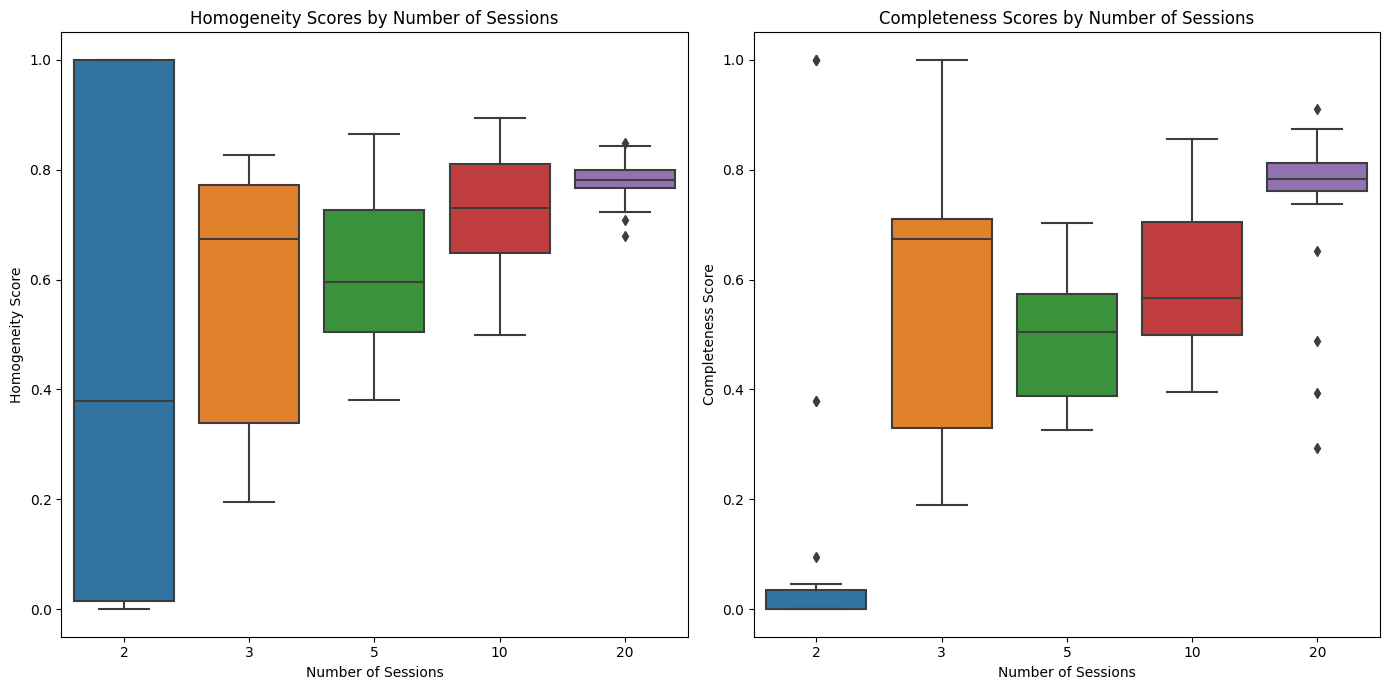

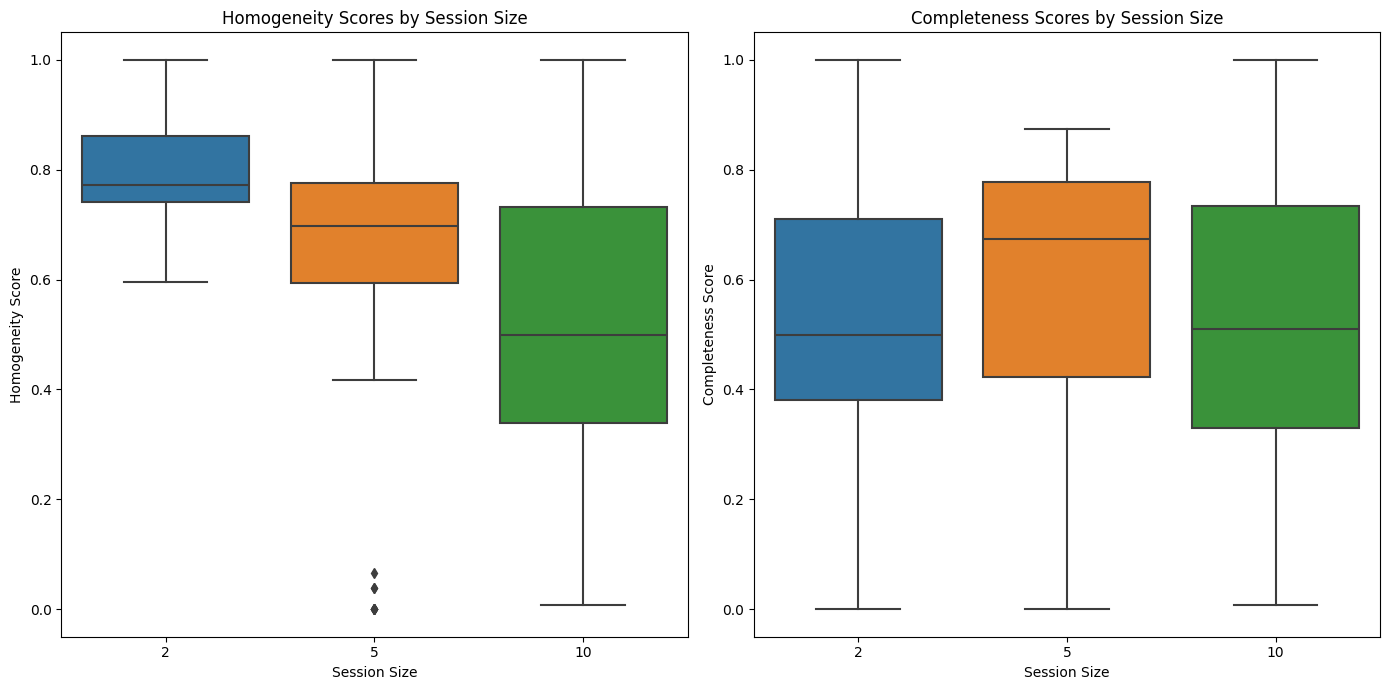

In [66]:
plt.figure(figsize=(14, 7))

# Homogeneity scores by number of sessions
plt.subplot(1, 2, 1)
sns.boxplot(data=score_df, x='num_sessions', y='homogeneity')
plt.title('Homogeneity Scores by Number of Sessions')
plt.xlabel('Number of Sessions')
plt.ylabel('Homogeneity Score')

# Completeness scores by number of sessions
plt.subplot(1, 2, 2)
sns.boxplot(data=score_df, x='num_sessions', y='completeness')
plt.title('Completeness Scores by Number of Sessions')
plt.xlabel('Number of Sessions')
plt.ylabel('Completeness Score')
plt.savefig("images/corrected_homogeneity.png")

plt.tight_layout()
plt.show()

# Similarly for session size, plotting
plt.figure(figsize=(14, 7))

# Homogeneity scores by session size
plt.subplot(1, 2, 1)
sns.boxplot(data=score_df, x='session_size', y='homogeneity')
plt.title('Homogeneity Scores by Session Size')
plt.xlabel('Session Size')
plt.ylabel('Homogeneity Score')

# Completeness scores by session size
plt.subplot(1, 2, 2)
sns.boxplot(data=score_df, x='session_size', y='completeness')
plt.title('Completeness Scores by Session Size')
plt.xlabel('Session Size')
plt.ylabel('Completeness Score')

plt.savefig("images/corrected_completeness.png")

plt.tight_layout()
plt.show()

In [82]:
data = []
# Extracting data from the dictionary
for key, value in all_results.items():
    # Start with key elements
    row = list(key)
    # Append dictionary items (flatten the dictionary to row)
    row.extend(value[1][1].values())
    # Append row to data list
    data.append(row)

# Define the column names, starting with those for the tuple, followed by dictionary keys
# columns = ['num_sessions', 'session_size', 'iteration'] + list(all_results[next(iter(all_results.keys()))])

# Create DataFrame
df_error_rates = pd.DataFrame(data)#, columns=columns)